In [10]:
import numpy as np
import pandas as pd
from glob import glob
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [24]:
#######################################
###                                 ###
###   STEP 1: Read and clean data   ###
###                                 ###
#######################################

class datacleaner():
    def __init__(self):
        # Get list of all files
        flist = glob('./rawfiles/*/*csv')
        # Parallel read the files
        dfs= Parallel(n_jobs=8)(delayed(pd.read_csv)(i) for i in flist)
        # Concatenate them vertically
        self.df = pd.concat(dfs)
        # Get datetime and drop unknowns
        self.clean()
        self.neg_outlier()
        # Drop low outliers
        self.drop_corr()
        # Drop corrected
        self.reset_index()
        # Group by datetime (sum of sizes and median of prices)
        self.aggregate()
        # Get hourly dataframe        
        self.get_hourly()
        # Write to files
        self.write()
        
    def clean(self):
        df = self.df
        # Only take trades from one exchange
        df = df[df.EX=='Q']
        # Remove 9999.999 values
        df = df.drop(df[df.PRICE>5000].index)
        
        df['DATETIME'] = df['DATE'].astype(str) + ' ' + df['TIME']
        df['DATETIME'] = pd.to_datetime(df['DATETIME'])

        self.df = df
        
        
    def neg_outlier(self):
        # rolling window to remove outliers at 60std
        prices = self.df.PRICE
        r = prices.rolling(window=4000)  # Create a rolling object 
        mps = r.mean() - 60. * r.std()  # Combine a mean and stdev on that object
        outliers = prices[prices < mps].index
        self.df = self.df.drop(outliers)
        
        
    def drop_corr(self):
        # Drop all items that are corrected (see Barndorff-Nielsen)
        self.df = self.df[self.df.CORR==0]
        self.df = self.df[self.df.COND.astype(str).apply(lambda x: 'F' in x or 'E' in x)]
        
    def reset_index(self):
        # Reset the index
        self.df = self.df.sort_values(by='DATETIME').reset_index().drop('index',axis=1)
        
    def aggregate(self):
        # Groupby datetime (e.g. two ticks at same moment become one)
        self.df = pd.DataFrame({'SIZE':self.df.groupby('DATETIME').SIZE.sum(),
                                'PRICE':self.df.groupby('DATETIME').PRICE.median()})
        
    def get_hourly(self):
        # Aggregate to hourly dateframe, just for visualization
        self.hourly=self.df.reset_index().resample('H', on='DATETIME').median()
        
    def write(self):
        # Write to pickle files
        self.df.to_pickle('AMZN_2007_2014.pickle')
        self.hourly.to_pickle('AMZN_hourly.pickle')
    
    def get_df(self):
        return self.df
        
reader = datacleaner()
df = reader.get_df()

In [25]:
df = pd.read_pickle('AMZN_2007_2014.pickle')

In [26]:
df

,SIZE,PRICE
DATETIME,,
2007-04-02 09:30:00,22372,39.79
2007-04-02 09:45:59,100,39.84
2007-04-02 09:58:00,300,39.94
2007-04-02 10:00:37,337,39.90
2007-04-02 10:01:08,1200,39.88
...,...,...
2014-12-31 15:59:55,810,310.29
2014-12-31 15:59:56,400,310.36
2014-12-31 15:59:57,400,310.28


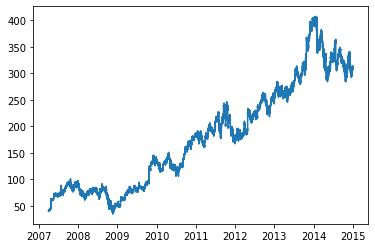

In [27]:
plt.plot(df.index, df.PRICE)
plt.show()

In [75]:
#######################################
###                                 ###
###    STEP 2: Daily volatility     ###
###                                 ###
#######################################


In [76]:
df

,SIZE,PRICE
DATETIME,,
2007-02-26 09:31:21,100,40.89
2007-02-26 09:38:10,400,41.13
2007-02-26 09:56:19,100,41.03
2007-02-26 09:56:24,100,41.03
2007-02-26 10:00:54,100,40.93
...,...,...
2014-12-31 15:59:55,1118,310.29
2014-12-31 15:59:56,400,310.36
2014-12-31 15:59:57,400,310.28
